<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/G_g_p_p0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import csv
import math
import numpy as np
from astropy.coordinates import cartesian_to_spherical
import pandas as pd
import scipy as sp
from sklearn.neighbors import KDTree
from scipy import optimize
from google.colab import files
from collections import Counter
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# RMC Cooling Schedules

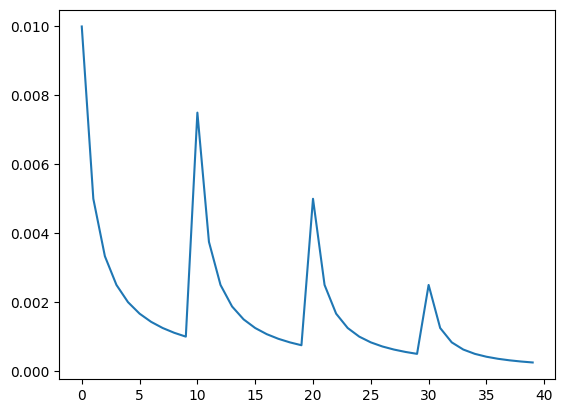

In [ ]:
# CHecks whether the sigams in RMC code are acting as thought
loop1 = 4
loop2 = 10
beta = 1
sig_0 = 0.01
sigmas = []
for i in np.arange(1,loop1+1,1):
  sig_1 = sig_0*(loop1-i+1)/loop1
  for j in np.arange(1,loop2+1,1):
    sig_2 = sig_1/(j*beta)
    sigmas.append(sig_2)
plt.plot(sigmas)

# FCC Nearest Neighbors

In [3]:
###############################################################################
# Data taken from a r=75A Au FCC Sphere
###############################################################################
NN_distance = [np.sqrt(1/2), np.sqrt(2/2), np.sqrt(3/2), np.sqrt(4/2), np.sqrt(5/2), np.sqrt(6/2), np.sqrt(7/2), np.sqrt(8/2), np.sqrt(9/2), np.sqrt(10/2),
            np.sqrt(11/2), np.sqrt(12/2), np.sqrt(13/2), np.sqrt(14/2), np.sqrt(15/2), np.sqrt(16/2), np.sqrt(17/2), np.sqrt(18/2), np.sqrt(19/2), np.sqrt(20/2),
            np.sqrt(21/2), np.sqrt(22/2), np.sqrt(23/2), np.sqrt(24/2), np.sqrt(25/2), np.sqrt(26/2), np.sqrt(27/2)]
NN_count = [12, 6, 24, 12, 24, 8, 48, 6, 36, 24,
         24, 24, 72, 0, 48, 12, 48, 30, 72, 24,
         48, 24, 48, 8, 84, 24, 96]

# G(r), g(r), $\rho(r)$, for a perfect lattice  

Text(0.5, 0, '$r(\\AA)$')

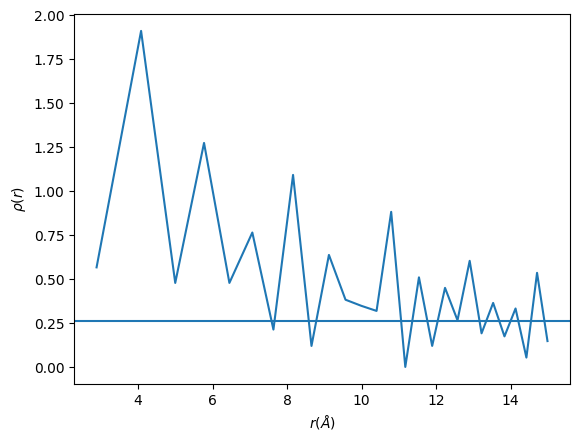

In [19]:
rho_0 = 0.263 # for FCC Au in a cube with lengths np.sqrt(27/2)*a where a = 4.0789 \AA
N = 886 #number of atoms out to 27th NN distance for a sphere

rho_r = [(1/(4*np.pi*NN_distance[i-1]*NN_distance[i-1])) * NN_count[i-1] for i in range(len(NN_count))]
plt.plot([i*4.0789 for i in NN_distance], rho_r)
plt.axhline(rho_0)
plt.ylabel(r'$\rho(r)$')
plt.xlabel(r'$r(\AA)$')

Text(0.5, 0, '$r(\\AA)$')

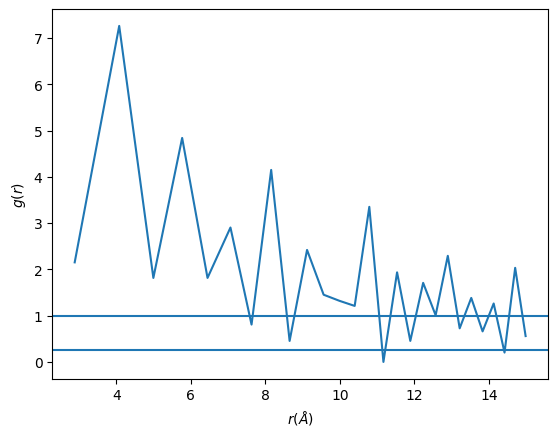

In [20]:
g_r = []
for x in rho_r:
  g_r.append(x/rho_0)
plt.plot([i*4.0789 for i in NN_distance], g_r)
plt.axhline(rho_0)
plt.axhline(1)
plt.ylabel(r'$g(r)$')
plt.xlabel(r'$r(\AA)$')

Text(0.5, 0, '$r(\\AA)$')

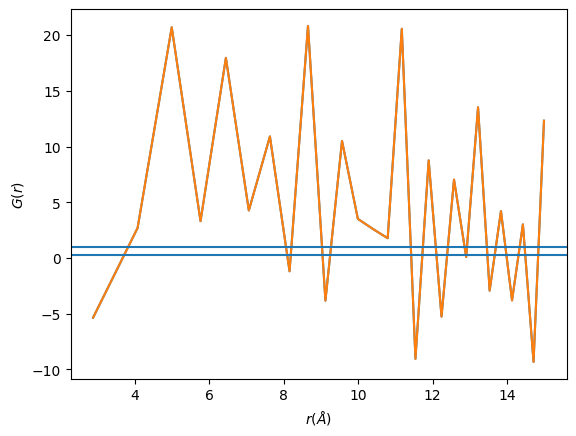

In [21]:
G_r1 = []
G_r2 = []

for i in range(len(rho_r)):
  G_r1.append(4*np.pi*NN_distance[i-1]*(rho_r[i-1]-rho_0))
  G_r2.append(4*np.pi*NN_distance[i-1]*rho_0*(g_r[i-1]-1))

plt.plot([i*4.0789 for i in NN_distance], G_r1)
plt.plot([i*4.0789 for i in NN_distance], G_r2)
plt.axhline(rho_0)
plt.axhline(1)
plt.ylabel(r'$G(r)$')
plt.xlabel(r'$r(\AA)$')

# G(r), g(r), $\rho(r)$ for a Terminating Au (r=25 A) Sphere

## How to Calculate All of the Atom to Atom Distances

In [22]:
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Control/STRs/Sphere100_Au_onAu_voidless.stru"
lp = 4.0789   # lattice paramter
N = 3925      # number of atoms

In [23]:
data = pd.read_csv(file, skiprows=3)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data["x"] = data["x"].astype(float)*lp
data["y"] = data["y"].astype(float)*lp
data["z"] = data["z"].astype(float)*lp
atom = data.atom
data = data.drop(data.columns[2], axis=1)
data

<ipython-input-23-c6a31c8fcca2>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


,y,z,x
0,-10.19725,-22.43395,-4.07890
1,-10.19725,-22.43395,0.00000
2,-10.19725,-22.43395,4.07890
3,-6.11835,-22.43395,-8.15780
4,-8.15780,-22.43395,-6.11835
...,...,...,...
3920,2.03945,24.47340,-2.03945
3921,0.00000,24.47340,0.00000
3922,2.03945,24.47340,2.03945
3923,0.00000,24.47340,4.07890


In [24]:
data_ar = data.to_numpy()
tree = KDTree(data_ar, leaf_size=2)
distances, ind = tree.query(data_ar, k=N-1)

distances = np.round(distances.flatten(),4)

## Calculating $\rho(r)$: number density of atoms

In [25]:
rho_0 = .05894 # for FCC Au with lp = 4.0789 \AA
const = 1/(4*np.pi*N)

In [26]:
c = Counter(distances)

In [29]:
rho_r = {}
for key in c:
  #print(key,c[key])
  rho_r[key] = 0.5*c[key]*const*(1/(key*key))

<ipython-input-29-2187b8e9a5ce>:4: RuntimeWarning: divide by zero encountered in double_scalars
  rho_r[key] = 0.5*c[key]*const*(1/(key*key))


Text(0.5, 0, '$r(\\AA)$')

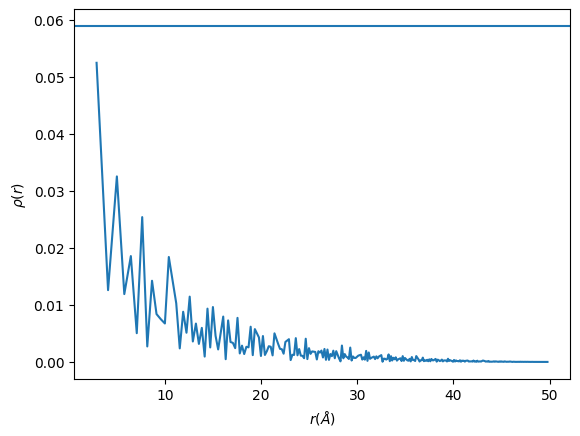

In [30]:
plt.plot(rho_r.keys(), rho_r.values())
plt.axhline(rho_0)
plt.ylabel(r'$\rho(r)$')
plt.xlabel(r'$r(\AA)$')

## Calculating g(r)

In [31]:
g_r = {}
for key in rho_r:
  g_r[key] = rho_r[key]/rho_0

Text(0.5, 0, '$r(\\AA)$')

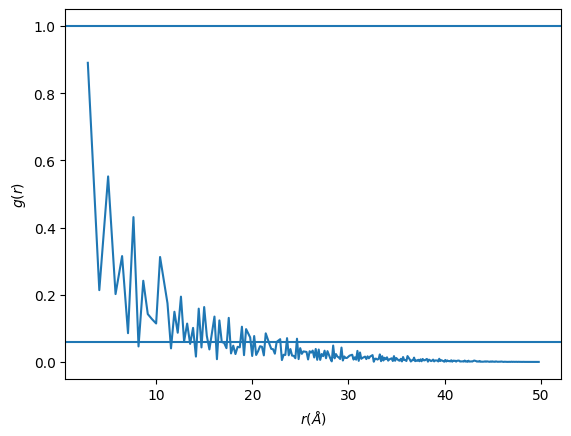

In [32]:
plt.plot(g_r.keys(), g_r.values())
plt.axhline(rho_0)
plt.axhline(1)
plt.ylabel(r'$g(r)$')
plt.xlabel(r'$r(\AA)$')

## Calculating G(r)

In [33]:
G_r = {}
for key in rho_r:
  G_r[key] = 4*np.pi*key*(rho_r[key]-rho_0)

<ipython-input-33-b971a060ed85>:3: RuntimeWarning: invalid value encountered in double_scalars
  G_r[key] = 4*np.pi*key*(rho_r[key]-rho_0)


In [34]:
slope = [-4*np.pi*key*rho_0 for key in G_r.keys()]

Text(0.5, 0, '$r(\\AA)$')

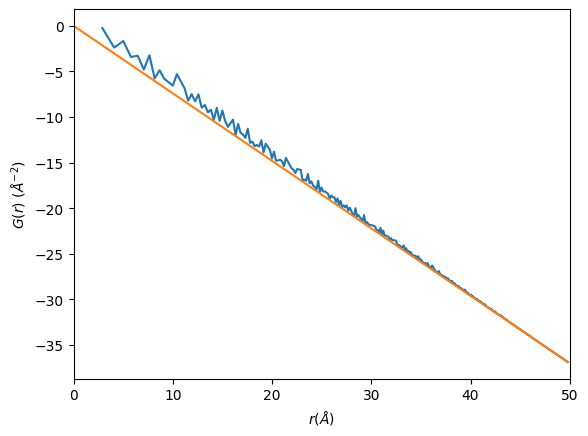

In [35]:
plt.plot(G_r.keys(), G_r.values())
plt.plot(G_r.keys(),slope)
plt.xlim(0,50)
plt.ylabel(r'$G(r)$ $(\AA^{-2})$')
plt.xlabel(r'$r(\AA)$')